In [1]:
import RtKernel as ker
import RtDlr as dlr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
    "font.size" : 8
})

In [45]:
beta = 20
N_max = 50
delta_t = 0.1
upper_cutoff = 500
lower_cutoff = 1.e-1
phi = np.pi/4
#set the values of m that should be explored
#h_vals = np.logspace(start=-2, stop=-1, num=10, base=10.0)[::-1]#time steps to explore
h_vals = np.log(np.arange(2,1.,-0.05))

Set frequency grid such that discrete integral is converged in m and n up to relative error epsilon (defined in cell below)

In [76]:
#compute continuous integral results
times = ker.set_time_grid(N_max=N_max, delta_t = delta_t)#time grid up to maximal time used
cont_integral = np.array([ker.cont_integral(t, beta, upper_cutoff) for t in times])#array containing all values for the continuous integration result

errors = np.zeros((len(h_vals)))
m_vals = np.zeros((len(h_vals)), dtype=np.int_)
n_vals = np.zeros((len(h_vals)), dtype=np.int_)

nbr_iterations = 0#count number of completed iterations through values of h

for i,h in enumerate(h_vals):

    #initialize m and n
    m_init = int(10. / h)
    n_init = int(5. / h)
    
    m = m_init
    n = n_init
    #discrete integral approximation for large m and n, i.e. the error is solely due to finite h and not due to finite m and n
    discr_integral_0 = np.array([ker.DiscrError(m_init, n_init, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

    #compute the error for very large m and n. In the following this will be used as epsilon, to estimate optimal m and n
    err = ker.DiscrError(m,n,N_max,delta_t,beta,upper_cutoff, h = h).error_time_integrated(time_series_exact=cont_integral, time_series_approx=discr_integral_0)
    
    if (i>0 and err > errors[i-1]) or err < 1.e-15:
        print('Attention: Either error does not shrink with h (problem with Finite m, n?) or machine precision error reached. Performed ' , nbr_iterations, ' iterations. Error = ' , err)
        break
    
    else:
        errors[i] = err
        
    epsilon = 1.e-0 * errors[i]#define error for estimate of m and n as this. Like this, the global error is guaranteed to be dominated by the effect from finite h and not from finite m or n.

    vary_m = True
    vary_n = True

    while vary_m:
        m -= 1
        # Evaluate DiscrError for varying m and n_init
        discr_integral_current = np.array([ker.DiscrError(m, n_init, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

        # Check if the error differs by more than epsilon
        rel_val_diff = np.sum(abs(discr_integral_current - discr_integral_0))/abs(np.sum(discr_integral_0))
        if rel_val_diff > epsilon:
            # If the value differs, halt iteration through m 
            #restore previous m
            m += 1
            m_vals[i] = m
            
            break
 

    while vary_n:
        n -= 1
        # Evaluate DiscrError for m_init and varying n
        discr_integral_current = np.array([ker.DiscrError(m_init, n, N_max, delta_t, beta, upper_cutoff, h=h).discrete_integral(t) for t in times])

        # Check if the error differs by more than epsilon
        rel_val_diff = np.sum(abs(discr_integral_current - discr_integral_0))/abs(np.sum(discr_integral_0))
        if rel_val_diff > epsilon:
            # If the value differs, fix the current values of n
            #restore previous n
            n += 1
            n_vals[i] = n
            break 

    nbr_iterations += 1#count number of completed iterations

h_vals = h_vals[:nbr_iterations]
errors = errors[:nbr_iterations]
m_vals = m_vals[:nbr_iterations]
n_vals = n_vals[:nbr_iterations]

Compute interpolative decomposition for errors determined in cell above

In [77]:
#compute ID and SVD
D =  np.array([dlr.RtDlr(N_max, delta_t, beta, upper_cutoff, m_vals[i], n_vals[i], eps = errors[i], h = h) for i,h in enumerate(h_vals)])

In [78]:
#Compute the time-integrated error between the original Green's function and the reconstructed Green's function for all values of h.
propagator_reconstr, propagator_errors = zip(
    *[d.reconstruct_propag(compute_error=True) for d in D]
)

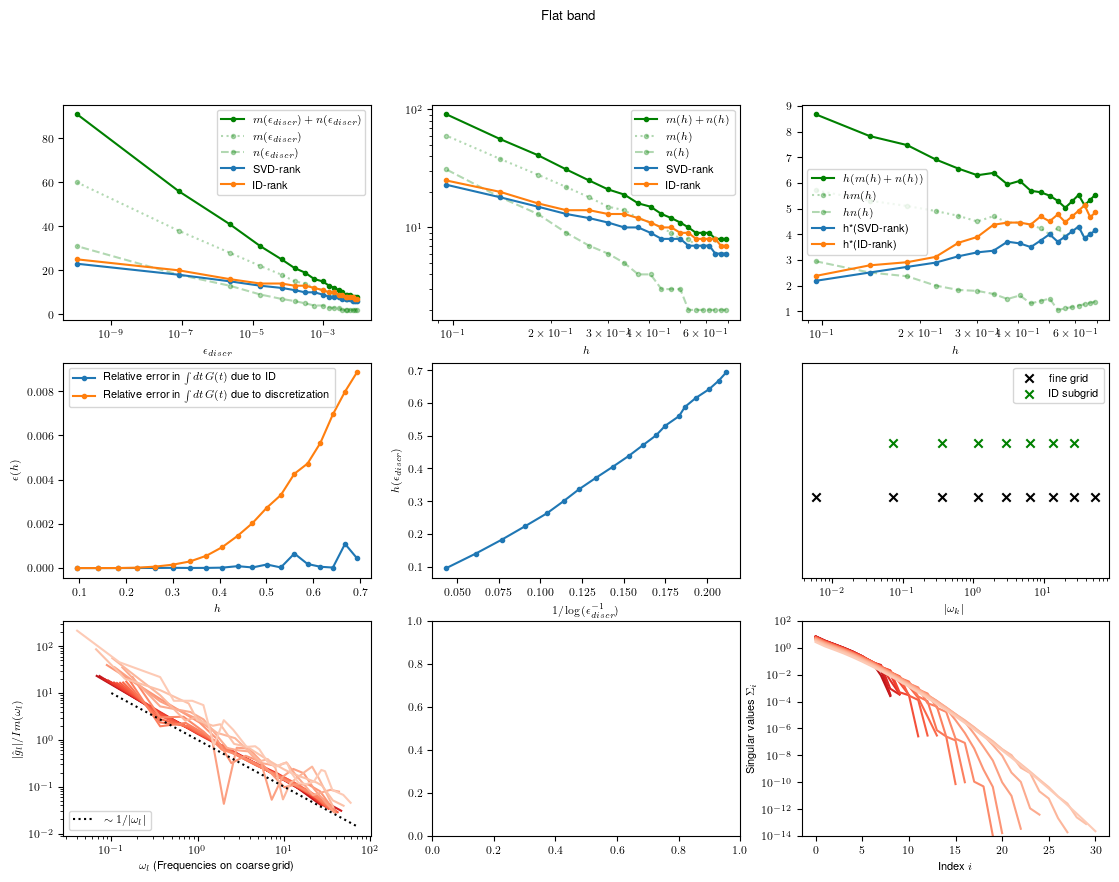

In [118]:
fig, axs = plt.subplots(3, 3, figsize=(13.5,9.5)) 
fig.suptitle('Flat band')

cmaps = [plt.get_cmap('Blues'), plt.get_cmap('Reds')]
colors_blue = cmaps[0](np.linspace(.8,0.2, nbr_iterations))
colors_orange = cmaps[1](np.linspace(.8,0.2, nbr_iterations))

axs[0,0].plot(errors,m_vals + n_vals, color = 'green', label=r'$m(\epsilon_{discr}) + n(\epsilon_{discr})$', marker='o', linestyle='-', markersize = 3)
axs[0,0].plot(errors,m_vals, color = 'green', label=r'$m(\epsilon_{discr})$', alpha = 0.3, linestyle = 'dotted', marker='o', markersize = 3)
axs[0,0].plot(errors,n_vals, color = 'green', label=r'$n(\epsilon_{discr})$', alpha = 0.3, linestyle = 'dashed', marker='o', markersize = 3)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0,0].plot(errors,num_sing_vals,  label= 'SVD-rank', marker='o', linestyle='-', markersize = 3)
ID_rank = np.array([d.ID_rank for d in D])
axs[0,0].plot(errors,ID_rank,  label= 'ID-rank', marker='o', linestyle='-', markersize = 3)
axs[0,0].set_xlabel(r'$\epsilon_{discr}$')
axs[0,0].legend()
axs[0,0].set_xscale('log')

axs[0,1].plot(h_vals,m_vals + n_vals, color = 'green', label=r'$m(h) + n(h)$', marker='o', linestyle='-', markersize = 3)
axs[0,1].plot(h_vals,m_vals, color = 'green', label=r'$m(h)$', alpha = 0.3, linestyle = 'dotted', marker='o', markersize = 3)
axs[0,1].plot(h_vals,n_vals, color = 'green', label=r'$n(h)$', alpha = 0.3, linestyle = 'dashed', marker='o', markersize = 3)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0,1].plot(h_vals,num_sing_vals,  label= 'SVD-rank', marker='o', linestyle='-', markersize = 3)
ID_rank = np.array([d.ID_rank for d in D])
axs[0,1].plot(h_vals,ID_rank,  label= 'ID-rank', marker='o', linestyle='-', markersize = 3)
axs[0,1].legend()
axs[0,1].set_xlabel(r'$h$')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')

axs[0,2].plot(h_vals,h_vals*(m_vals + n_vals), color = 'green', label=r'$h(m(h) + n(h))$', marker='o', linestyle='-', markersize = 3)
axs[0,2].plot(h_vals,h_vals*m_vals, color = 'green', label=r'$h m(h)$', alpha = 0.3, linestyle = 'dotted', marker='o', markersize = 3)
axs[0,2].plot(h_vals,h_vals*n_vals, color = 'green', label=r'$hn(h)$', alpha = 0.3, linestyle = 'dashed', marker='o', markersize = 3)
num_sing_vals = np.array([d.num_singular_values_above_threshold for d in D])
axs[0,2].plot(h_vals,h_vals*num_sing_vals,  label= 'h*(SVD-rank)', marker='o', linestyle='-', markersize = 3)
ID_rank = np.array([d.ID_rank for d in D])
axs[0,2].plot(h_vals,h_vals*ID_rank,  label= 'h*(ID-rank)', marker='o', linestyle='-', markersize = 3)
axs[0,2].set_xlabel(r'$h$')
axs[0,2].legend()
axs[0,2].set_xscale('log')


axs[1,0].plot(h_vals, propagator_errors, label = 'Relative error in ' + r'$\int dt\, G(t)$' + ' due to ID', marker='o', linestyle='-', markersize = 3)
axs[1,0].plot(h_vals, errors, label = 'Relative error in ' + r'$\int dt\,G(t)$' + ' due to discretization', marker='o', linestyle='-', markersize = 3)
axs[1,0].set_xlabel(r'$h$')
axs[1,0].set_ylabel(r'$\epsilon(h)$')
#axs[1,0].set_yscale('log')
#axs[1,0].set_xscale('log')
axs[1,0].legend()


axs[1,1].plot(1/np.log(1/errors), h_vals, marker='o', linestyle='-', markersize = 3)
axs[1,1].set_xlabel(r'$1/\log(\epsilon_{discr}^{-1})$')
axs[1,1].set_ylabel(r'$h(\epsilon_{discr})$')
#axs[1,1].legend()


fine_grid = D[1].fine_grid # fine grid at some index, here chosen to be len(D)//2
coarse_grid = D[1].coarse_grid # coarse grid at some index, here chosen to be len(D)//2
axs[1,2].scatter(fine_grid,len(fine_grid) * [0], color = 'black', label = 'fine grid', marker='x')
axs[1,2].scatter(coarse_grid,len(coarse_grid) * [0.1],  color = 'green', label = 'ID subgrid', marker='x')
axs[1,2].set_ylim(bottom = -0.15, top = 0.25)
#axs[1,2].set_xlim(left = 1.e-2, right = 70)
axs[1,2].set_xscale('log')
axs[1,2].set_xlabel(r'$|\omega_k|$')
axs[1,2].yaxis.set_visible(False)
axs[1,2].legend()



for c,d in enumerate(D):
    couplings_eff = d.coupl_eff()
    coarse_grid = d.coarse_grid
    arg_sort_coarse = np.argsort(coarse_grid)
    axs[2,0].plot(np.sort(coarse_grid), abs(couplings_eff[arg_sort_coarse])/np.imag(coarse_grid[arg_sort_coarse] * np.exp(1.j * phi)), color = colors_orange[c])

axs[2,0].set_ylabel(r'$|\hat{g}_l| / Im(\omega_l)$')
axs[2,0].set_xlabel(r'$\omega_l$' + ' (Frequencies on coarse grid)')
axs[2,0].set_yscale('log')
axs[2,0].set_xscale('log')
#axs[2,0].text(1,11,'lighter = finer grid \n Note log-log scale')
axs[2,0].plot(np.linspace(0.1,70), 1/np.linspace(0.1,70),linestyle = 'dotted', label= r'$\sim 1/|\omega_l|$', color = 'black')
axs[2,0].legend(loc = 'lower left')



for c,d in enumerate(D):
    singular_values = d.singular_values
    del_sing_vals = [i for i, sigma in enumerate(singular_values) if abs(sigma) < 1.e-14]
    singular_values = np.delete(singular_values,del_sing_vals)
    axs[2,2].plot(np.arange(len(singular_values)), singular_values, color = colors_orange[c])
axs[2,2].set_xlabel('Index ' + r'$i$')
axs[2,2].set_ylabel('Singular values ' + r'$\Sigma_i$')
axs[2,2].set_yscale('log')
axs[2,2].set_ylim(bottom = 1.e-14, top = 100)


plt.savefig('./plots/overview_flatband.pdf')